# Import Packages

In [2]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     |################################| 366 kB 3.2 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pytz 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ast
import string
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator

# Import Data

In [11]:
df = pd.read_csv('data_tweet_vaksinasi_cleaned_stemmed.csv')
df["text"] = [str(x).replace(',',' ') for x in df["text"]]

In [12]:
df.head(10)

,created_at,user,location,coordinates,text,retweet_count,favorite_count,id,nama_kota,avg_word,word_count
0,2021-08-14 14:53:43,restrotangkot,"Jl. Daan Mogot No.5, Tangerang",NaN,jajar polsek ciledug polres metro tangerang pi...,0,0,ID3172,JAKARTA TIMUR,6.125000,21
1,2021-08-14 14:53:42,dryxanne,Jakarta,NaN,habis tu bangun lsg brasa lrga hanya mimpi seg...,0,0,ID3172,JAKARTA TIMUR,5.000000,26
2,2021-08-14 14:53:24,bukanlucinta,"Jakarta, Indonesia.",NaN,bertanyarl lho syukur bisa astra arti sehat ba...,0,0,ID3172,JAKARTA TIMUR,5.461538,24
3,2021-08-14 14:53:09,mporatne,"DKI Jakarta, Indonesia",NaN,trianadewi dipegangin bupati biar tidak takut,0,0,ID3172,JAKARTA TIMUR,6.666667,11
4,2021-08-14 14:52:20,whopsy_opsy,Jakarta,NaN,buset habis makan melulu,0,0,ID3172,JAKARTA TIMUR,5.250000,6
5,2021-08-14 14:51:43,agus_harimin,bekasi,NaN,fre desain katau buah sisi gambar mesan whatsa...,0,0,ID3172,JAKARTA TIMUR,6.538462,27
6,2021-08-14 14:51:29,PuntenMauJualan,"Jakarta Utara, DKI Jakarta",NaN,pandemi seperti barang seperti milik ohqsembil...,0,0,ID3172,JAKARTA TIMUR,7.000000,23
7,2021-08-14 14:50:46,contactap2,"Tangerang, Indonesia",NaN,ranranseratus perihal kuota batas imbau jam be...,0,0,ID3172,JAKARTA TIMUR,6.636364,26
8,2021-08-14 14:50:34,contactap2,"Tangerang, Indonesia",NaN,ranranseratus perihal registrasi daftar langsu...,0,0,ID3172,JAKARTA TIMUR,7.333333,27
9,2021-08-14 14:50:00,mediaindonesia,Jakarta - Indonesia,NaN,sinopharm guna negara menteri sehat arab saudi...,1,1,ID3172,JAKARTA TIMUR,6.777778,20


In [13]:
len(df)

5380

Removing Duplicate if any

In [14]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [15]:
len(df)

5380

# Extra Cleaning

In [17]:
len(df[df['text'].isnull()==True])

0

In [18]:
df = df.dropna(subset=['text'])
df = df.reset_index(drop=True)

In [19]:
df.isnull().sum()

created_at           0
user                 0
location            89
coordinates       5367
text                 0
retweet_count        0
favorite_count       0
id                   0
nama_kota            0
avg_word             0
word_count           0
dtype: int64

In [21]:
def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

def clean_tweets(tweet):
   # nltk.download('stopwords')
    my_file = open("combined_stop_words.txt", "r")
    content = my_file.read()
    stop_words = content.split("\n")
    file_2  = open("update_combined_slang_words.txt", "r")
    content2 = file_2.read()
    slang_words = ast.literal_eval(content2)
    my_file.close()
    file_2.close()

    tweet = tweet.lower()
    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    #remove emojis from tweet
    #tweet = emoji_pattern.sub(r'', tweet)
    
    #remove punctuation manually
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    
    #remove tags
    tweet=re.sub("&lt;/?.*?&gt;","&lt;&gt;",tweet)
    
    #remove digits and special chars
    tweet=re.sub("(\\d|\\W)+"," ",tweet)

    #remove other symbol from tweet
    tweet = re.sub(r'â', '', tweet)
    tweet = re.sub(r'€', '', tweet)
    tweet = re.sub(r'¦', '', tweet)

    word_tokens = word_tokenize(tweet)
    for w in word_tokens:
        if w in slang_words.keys():
            word_tokens[word_tokens.index(w)] = slang_words[w]

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []

    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in string.punctuation:
            filtered_tweet.append(w.lower())
    return ' '.join(filtered_tweet)

def count_words(x):
    words = word_tokenize(x)
    n=len(words)
    return n

Recleaning after remove exaggeration

# Word Processing

## Create word dictionary

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/covanvers/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
word_dict = {}
for i in range(0,len(df['text'])):
    sentence = df['text'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [25]:
len(word_dict)

14908

In [26]:
len({k:v for (k,v) in word_dict.items() if v < 4})

12836

## Import Lexicon data

import lexicon, and remove negation words from lexicon, the lexicon is a combination from several sources below, that combined together, and include swear words which has the most negative score

sources : <br>
https://github.com/louisowen6/NLP_bahasa_resources <br>
https://github.com/abhimantramb/elang/blob/master/word2vec/utils/swear-words.txt <br>
https://github.com/fajri91/InSet <br>
https://github.com/agusmakmun/SentiStrengthID/blob/master/id_dict/sentimentword.txt 

In [27]:
negasi = ['bukan','tidak','ga','gk']
lexicon = pd.read_csv('modified_full_lexicon.csv')
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')
                               |(lexicon['word'] == 'tidak')
                               |(lexicon['word'] == 'ga')|(lexicon['word'] == 'gk') ].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [28]:
len(lexicon)

10248

In [29]:
lexicon.head(10)

,word,weight,number_of_words
0,hai,3,1
1,merekam,2,1
2,ekstensif,3,1
3,paripurna,1,1
4,detail,2,1
5,pernik,3,1
6,belas,2,1
7,welas,4,1
8,kabung,1,1
9,rahayu,4,1


In [30]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

In [31]:
len(lexicon_word)

10248

Checking if there is words in dictionary that does not included in the lexicon

Let's take a look what kind of words they are, lets start with some words that have many occurences as this most likely not  a type case

In [33]:
len({k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3)) })

975

In [34]:
ns_words_list = {k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3))}

It turns out that the words that is not included in lexicon, are the one that not have signifance sentiment

In [35]:
sort_orders = sorted(ns_words_list.items(), key=lambda x: x[1], reverse=True)
sort_orders=sort_orders[0:20]
for i in sort_orders:
    print(i[0], i[1])

tidak 920
bisa 388
belum 303
kasus 286
pasien 135
bukan 111
bahkan 102
kok 102
virus 69
kembali 69
laku 67
padahal 67
negara 66
jalan 64
suntik 63
update 61
giat 60
meningal 60
pramuka 59
aman 58


In [36]:
word_to_plot = df['text'].copy()

In [37]:
word_to_plot_1 = word_to_plot.apply(lambda x: del_word(x,negasi))

creating word cloud to see what kind of words that appear often in the tweets related to the pandemic

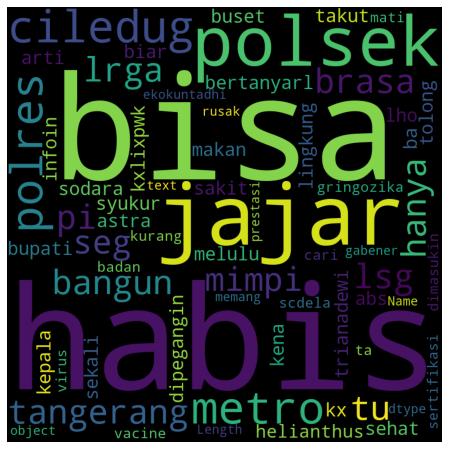

In [38]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', max_words = 1000
                      , min_font_size = 20).generate(str(word_to_plot_1))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## sentiment

In [39]:
lexicon['number_of_words'].value_counts()

1    9536
2     686
3      24
4       2
Name: number_of_words, dtype: int64

calculating the sentiment of words by mathing them to the lexicon while also creating the bag of words matrix

In [40]:
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['text'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # if not, then check the root word
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # if still negative, try to match the combination of words with the adjacent words
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [41]:
len(sentiment_list)

5380

In [42]:
print(senrow.shape[0])

5380


constructing the data frame that contain bag of words and the sentiments that have been calculated before

In [43]:
sencol.append('sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [48]:
df_sen.head(10)

,kuning,buka,dampak,kecil,kajian,terkait,normal,celaka,nyinyir,sakit,...,mangkel,seni,realitas,menjemukan,respons,kacuk,mengucapkan,mewujudkan,tara,sentiment
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-4
1,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,1,1,2,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,11


lets see if the sentiment is correct by looking at the original text

In [44]:
cek_df = pd.DataFrame([])
cek_df['text'] = df['text'].copy()
cek_df['sentiment']  = df_sen['sentiment'].copy()

In [45]:
cek_df.head(10)

,text,sentiment
0,jajar polsek ciledug polres metro tangerang pi...,2
1,habis tu bangun lsg brasa lrga hanya mimpi seg...,-4
2,bertanyarl lho syukur bisa astra arti sehat ba...,19
3,trianadewi dipegangin bupati biar tidak takut,0
4,buset habis makan melulu,1
5,fre desain katau buah sisi gambar mesan whatsa...,8
6,pandemi seperti barang seperti milik ohqsembil...,-6
7,ranranseratus perihal kuota batas imbau jam be...,-8
8,ranranseratus perihal registrasi daftar langsu...,4
9,sinopharm guna negara menteri sehat arab saudi...,5


In [47]:
df['sentiment'] = df_sen['sentiment'].copy()
df

,created_at,user,location,coordinates,text,retweet_count,favorite_count,id,nama_kota,avg_word,word_count,sentiment
0,2021-08-14 14:53:43,restrotangkot,"Jl. Daan Mogot No.5, Tangerang",NaN,jajar polsek ciledug polres metro tangerang pi...,0,0,ID3172,JAKARTA TIMUR,6.125000,21,2
1,2021-08-14 14:53:42,dryxanne,Jakarta,NaN,habis tu bangun lsg brasa lrga hanya mimpi seg...,0,0,ID3172,JAKARTA TIMUR,5.000000,26,-4
2,2021-08-14 14:53:24,bukanlucinta,"Jakarta, Indonesia.",NaN,bertanyarl lho syukur bisa astra arti sehat ba...,0,0,ID3172,JAKARTA TIMUR,5.461538,24,19
3,2021-08-14 14:53:09,mporatne,"DKI Jakarta, Indonesia",NaN,trianadewi dipegangin bupati biar tidak takut,0,0,ID3172,JAKARTA TIMUR,6.666667,11,0
4,2021-08-14 14:52:20,whopsy_opsy,Jakarta,NaN,buset habis makan melulu,0,0,ID3172,JAKARTA TIMUR,5.250000,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5375,2021-08-13 5:41:58,dityaawahyu,"Pamulang, Indonesia",NaN,sodara lingkung kena tolong infoin kxlixpwk kx...,3,1,ID3171,JAKARTA SELATAN,6.714286,24,0
5376,2021-08-13 19:45:00,dicxvlr,"Tangerang, INDONESIA",NaN,sakit kepala sekali abs,0,0,ID3173,JAKARTA PUSAT,5.000000,5,-6
5377,2021-08-13 5:01:52,vascodagambir,"Cikarang, Indonesia",NaN,helianthus an gringozika dimasukin virus mati nis,0,0,ID3173,JAKARTA PUSAT,6.142857,15,4
5378,2021-08-13 5:01:25,rakapradana07,"Jakarta Capital Region, Indonesia",NaN,cari badan sertifikasi vacine ta kurang scdela...,0,0,ID3173,JAKARTA PUSAT,6.250000,27,-12


In [55]:
conditions = [
    (df['sentiment'] < 0),
    (df['sentiment'] >= 0) & (df['sentiment'] <= 5),
    (df['sentiment'] > 5),
    ]

In [56]:
values = ['Negatif', 'Netral', 'Positif']

In [57]:
df['analysis'] = np.select(conditions, values)

In [60]:
df.head()

,created_at,user,location,coordinates,text,retweet_count,favorite_count,id,nama_kota,avg_word,word_count,sentiment,analysis
0,2021-08-14 14:53:43,restrotangkot,"Jl. Daan Mogot No.5, Tangerang",NaN,jajar polsek ciledug polres metro tangerang pi...,0,0,ID3172,JAKARTA TIMUR,6.125000,21,2,Netral
1,2021-08-14 14:53:42,dryxanne,Jakarta,NaN,habis tu bangun lsg brasa lrga hanya mimpi seg...,0,0,ID3172,JAKARTA TIMUR,5.000000,26,-4,Negatif
2,2021-08-14 14:53:24,bukanlucinta,"Jakarta, Indonesia.",NaN,bertanyarl lho syukur bisa astra arti sehat ba...,0,0,ID3172,JAKARTA TIMUR,5.461538,24,19,Positif
3,2021-08-14 14:53:09,mporatne,"DKI Jakarta, Indonesia",NaN,trianadewi dipegangin bupati biar tidak takut,0,0,ID3172,JAKARTA TIMUR,6.666667,11,0,Netral
4,2021-08-14 14:52:20,whopsy_opsy,Jakarta,NaN,buset habis makan melulu,0,0,ID3172,JAKARTA TIMUR,5.250000,6,1,Netral


In [61]:
df.to_csv("data_tweet_vaksinasi_sentiment_v2.csv", index=False)

In [62]:
df

,created_at,user,location,coordinates,text,retweet_count,favorite_count,id,nama_kota,avg_word,word_count,sentiment,analysis
0,2021-08-14 14:53:43,restrotangkot,"Jl. Daan Mogot No.5, Tangerang",NaN,jajar polsek ciledug polres metro tangerang pi...,0,0,ID3172,JAKARTA TIMUR,6.125000,21,2,Netral
1,2021-08-14 14:53:42,dryxanne,Jakarta,NaN,habis tu bangun lsg brasa lrga hanya mimpi seg...,0,0,ID3172,JAKARTA TIMUR,5.000000,26,-4,Negatif
2,2021-08-14 14:53:24,bukanlucinta,"Jakarta, Indonesia.",NaN,bertanyarl lho syukur bisa astra arti sehat ba...,0,0,ID3172,JAKARTA TIMUR,5.461538,24,19,Positif
3,2021-08-14 14:53:09,mporatne,"DKI Jakarta, Indonesia",NaN,trianadewi dipegangin bupati biar tidak takut,0,0,ID3172,JAKARTA TIMUR,6.666667,11,0,Netral
4,2021-08-14 14:52:20,whopsy_opsy,Jakarta,NaN,buset habis makan melulu,0,0,ID3172,JAKARTA TIMUR,5.250000,6,1,Netral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,2021-08-13 5:41:58,dityaawahyu,"Pamulang, Indonesia",NaN,sodara lingkung kena tolong infoin kxlixpwk kx...,3,1,ID3171,JAKARTA SELATAN,6.714286,24,0,Netral
5376,2021-08-13 19:45:00,dicxvlr,"Tangerang, INDONESIA",NaN,sakit kepala sekali abs,0,0,ID3173,JAKARTA PUSAT,5.000000,5,-6,Negatif
5377,2021-08-13 5:01:52,vascodagambir,"Cikarang, Indonesia",NaN,helianthus an gringozika dimasukin virus mati nis,0,0,ID3173,JAKARTA PUSAT,6.142857,15,4,Netral
5378,2021-08-13 5:01:25,rakapradana07,"Jakarta Capital Region, Indonesia",NaN,cari badan sertifikasi vacine ta kurang scdela...,0,0,ID3173,JAKARTA PUSAT,6.250000,27,-12,Negatif
